# picd : Python Implementation of Causal Discovery

##  picd.causal_discovery.constraint_based_algorithm.cpc

Basic algorithm of many constraint-based algorithm(ex : pc algorithm).


**\[Assumption\]**


- No hidden confounder Assumption
- Markov Causal Assumption
- Faithfulness Assumption


**\[Process\]**

- Find Skeleton by relation of adjacency and d-separation**
- **→ Find V-structure by lemma 1 (Verma and Pearl, 1991)**
- **→ Apply Meek’s rule (Meek, 1995)**
- **→ Proof Soundness and Completeness with DAG pattern by the theorem of Meek (Meek, 1995)**


For more information, see *Note* below.


### class picd.causal_discovery.constraint_based_algorithm.basic(void)

#### Methods

##### identify(data:pd.DataFrame, ind:str) -> picd.pattern



*   Return : DAG pattern



###### Pseudo Code

Metropolitan, 2004, Learning Bayesian Networks, chapter 10, pp.546



```
Problem : Given a set IND of d-separations, determine the DAG pattern faithful
to IND if there is one

Input : a set V of nodes and a set IND of d-separations among subsets of the
nodes

Outputs : If IND admits a faithful DAG representation, the DAG pattern gp
containing the d-separations in this set

# The original code is C-style, so I modify the code to be similar to Python style.
# Warning : the notations in this code are not in the original code. I wrote it. 
#           So, the notations are possibly wrong

def find_DAG_pattern(V, IND, Empty Graph G) -> Graph G:
	S[(x,y)] <- A list containing the set Sxy 
							that render X and Y are conditional independent

	for each pair of nodes (X, Y) in V:
		# step 0
		for subset S_ in V/{X, Y}:
			if I({X},{Y}|S_) in IND: 
				S[(X,Y)].append(S_)
		
		if S[(X,Y)] is empty:
			# step 1
			# Lemma 1, Verma and Pearl, 1991, On the Equivalence of Causal Models
			# https://arxiv.org/abs/1304.1108
			# S[(X, Y)] is empty <-> X and Y are adjacent
			create the link X - Y in G
	
	for each uncoupled meeting X - Z - Y in V:
		# step 2
		# v-structure property
		if Z not in every S in S[(X, Y)]:
			orient X - Z - Y as X -> Z <- Y
	
	while more edges can be oriented:
		# step 3
		for each uncoupled meeting X -> Z - Y:
			# X -> Z - Y is not v-structure, therefore 
			orient Z - Y  as Z -> Y
		# step 4
		for each link X - Y such that there is a path from X to Y:
			# Given graph G is DAG, therefore there is not cyclic path between X and Y
			# However, if Y -> X, then there is cyclic path : X -> ... -> Y -> X
			# thus
			orient X - Y as X -> Y
		# step 5
		for each uncoupled meeting X - Z - Y such that X -> W, Y -> W, and Z - W:
			# X - Z - Y is not v-structure -> Z is parent of either X or Y
			# if Z <- W, there is cyclic path through either X or Y 
			# thus
			orient Z - W as Z -> W
	

	return G
  ```



###### Source Code

#### Note

### Example

#### Example

In [278]:
from tqdm import tqdm
from collections import deque
from itertools import combinations, chain
from collections import defaultdict
# from ..pattern import pattern

def identify_skeleton_from_empty_graph(self, data, test_kwarg):
    self.ptn = pattern()
    self.ptn.add_vertex(list(data.columns))

    self.p_independence_set = defaultdict(set)
    self.p_independence_set = defaultdict(lambda: defaultdict(set))
    
    pairs = combinations(self.ptn.vertex, 2)
    for x, y in pairs:
        v_not_x_y = list(self.ptn.vertex - {x, y})
        power_set_of_v_not_x_y = chain(*[combinations(v_not_x_y, n) for n in range(len(v_not_x_y) + 1)])
        for subset in power_set_of_v_not_x_y:
            if self.test(data, {x}, {y}, set(subset), **test_kwarg):
                self.p_independence_set[x][y]
                self.p_independence_set[y][x] = self.p_independence_set[x][y]
                self.p_independence_set[x][y].add(subset)
                # self.p_independence_set[y][x].add(subset)

    self.identify_skeleton_by_ind(self.p_independence_set)

def identify_skeleton_by_ind(self, ind, vertex:set = None):
    if vertex is not None: self.ptn.add_vertex(vertex)
    
    self.p_independence_set = ind
    pairs = combinations(self.ptn.vertex, 2)

    for x, y in pairs:
        if len(self.p_independence_set[x][y]) == 0:
            self.ptn.add_link(x, y)
    

def identify_v_structure_with_adjacency_orient_faithfulness(self):
    uncoupled_triple = deque()
    for x in self.ptn.link.keys():
        for z in self.ptn.link[x].keys():
            for y in self.ptn.link[z].keys():
                # Test x-z-y is uncoulped meeting
                if x != y and not self.ptn.is_adjacent(x, y): 
                    if all(z not in subset for subset in self.p_independence_set[x][y]) : uncoupled_triple.append((x, y, z))
    
    while uncoupled_triple:
        x, y, z = uncoupled_triple.popleft()
        #if Z not in every S in S[(X, Y)]:
        # orient X - Z - Y as X -> Z <- Y
        self.ptn.remove_links([(x,z), (y,z)])
        self.ptn.add_edges([(x,z), (y,z)])


def identify_meeks_rule_2(self):
    uncoupled_triple = deque()
    for x in self.ptn.child.keys():
        for z in self.ptn.child[x].keys():
            for y in self.ptn.link[z].keys():
                # Test x-z-y is uncoulped meeting
                if x != y and not self.ptn.is_adjacent(x, y): uncoupled_triple.append((x, y, z))

    if len(uncoupled_triple) == 0: return False

    while uncoupled_triple:
        x, y, z = uncoupled_triple.popleft()
        # X -> Z - Y is not v-structure, therefore 
        # orient Z - Y  as Z -> Y
        self.ptn.remove_links([(y,z)])
        self.ptn.add_edges([(z,y)])

    return True


def identify_meeks_rule_3(self):
    pairs = deque()
    for x in self.ptn.link.keys():
        for y in self.ptn.link[x].keys(): 
            if len(self.ptn.get_path(x, y, directed=True)) > 0: pairs.append((x, y))
    
    if len(pairs) == 0: return False

    while pairs:
        x, y = pairs.popleft()
        #Given graph G is DAG, therefore there is not cyclic path between X and Y
        # However, if Y -> X, then there is cyclic path : X -> ... -> Y -> X
            # thus orient X - Y as X -> Y
        self.ptn.remove_links([(x,y)])
        self.ptn.add_edges([(x,y)])
    
    return True


def identify_meeks_rule_4(self):
    pairs = deque()
    for w in self.ptn.parent.keys():
        # Find W which has more than two parents and vertex Z linked with
        if len(self.ptn.parent[w].keys()) >= 2 and w in self.ptn.link.keys():
            linked_with_w = set(self.ptn.link[w].keys())

            # Find pair of parents of W (x, y) such that x is not adjacent with y
            # X   Y
            #  \ /
            #   ><
            #   W
            parent_of_w = list(self.ptn.parent[w].keys())
            xy = combinations(parent_of_w, 2)

            for x, y in xy:
                if not self.ptn.is_adjacent(x, y):

                    # Find Z such that X - Z, Y - Z, and W - Z
                    linked_with_x = set(self.ptn.link[x].keys())
                    linked_with_y = set(self.ptn.link[y].keys())
                    linked_with_x_y_w = linked_with_w & linked_with_x & linked_with_y

                    for z in linked_with_x_y_w: pairs.append((z, w))
    
    if len(pairs) == 0: return False
    while pairs:
        z, w = pairs.popleft()
        # Now, we know that 
        # X - Z - Y
        #  \  |  /
        #   > W <
        # X - Z - Y is not v-structure -> Z is parent of X or Y
        # if Z <- W, there is cyclic path through X or Y 
        # thus orient Z - W as Z -> W

        self.ptn.remove_links([(z,w)])
        self.ptn.add_edges([(z,w)])

    return True


def identify_skeleton_from_full_link_graph(self, data, test_kwarg):
    self.ptn = pattern()
    self.ptn.add_vertex(list(data.columns))

    self.p_independence_set = defaultdict(set)
    self.p_independence_set = defaultdict(lambda: defaultdict(set))

    # Lemma 1, Verma and Pearl, 1991, On the Equivalence of Causal Models
	# X and Y are adjacent 
	# <-> X and Y are not d-separated by any subset of PA_X or PA_Y

	# => X and Y are not adjacent 
	# <-> X and Y are d-separated by some subset of PA_X or PA_Y

	# therefore, we do not have to check d-separation for every possible subset S, 
    # only have to do for subsets of PA_X or PA_Y

    self.ptn.full_link()

    adj = {x : self.ptn.adjacent(x) for x in self.ptn.vertex}
    
    i = 0
    while any(i < len(adj[x]) for x in adj.keys()):
        i += 1

        for x in self.ptn.vertex:
            adj_x = adj[x]

            for y in adj_x:
                adj_x_not_y = list(adj_x - {y})
                power_set = chain(*[combinations(adj_x_not_y, n) for n in [0, i]])
                for subset in power_set:
                    if self.test(data, {x}, {y}, set(subset), **test_kwarg):
                        self.p_independence_set[x][y]
                        self.p_independence_set[y][x] = self.p_independence_set[x][y]
                        self.p_independence_set[x][y].add(subset)

                        self.ptn.remove_links([(x, y)])
                        # adj[x].discard(y)
                        # adj[y].discard(x)
            
            adj[x] = self.ptn.adjacent(x)


def identify_v_structure_with_adjacency_faithfulness(self):
    uncoupled_triple = deque()
    self.unfaithful_triple = set()
    for x in self.ptn.link.keys():
        for z in self.ptn.link[x].keys():
            for y in self.ptn.link[z].keys():
                # Test x-z-y is uncoulped meeting
                if x != y and not self.ptn.is_adjacent(x, y): 
                    if all(z not in subset for subset in self.p_independence_set[x][y]) : uncoupled_triple.append((x, y, z))
                    elif all(z in subset for subset in self.p_independence_set[x][y]) : continue
                    else: self.unfaithful_triple.add((x,z,y))
                    
    while uncoupled_triple:
        x, y, z = uncoupled_triple.popleft()
        #if Z not in every S in S[(X, Y)]:
        # orient X - Z - Y as X -> Z <- Y
        self.ptn.remove_links([(x,z), (y,z)])
        self.ptn.add_edges([(x,z), (y,z)])

def identify_meeks_rule_2_in_cpc(self):
    uncoupled_triple = deque()
    for x in self.ptn.child.keys():
        for z in self.ptn.child[x].keys():
            for y in self.ptn.link[z].keys():
                # Check whether the triple x->z-y is unfaithful or not
                # If unfaithful, pass
                if (x,z,y) in self.unfaithful_triple : continue
                
                # Test x->z-y is uncoulped meeting
                if x != y and not self.ptn.is_adjacent(x, y): uncoupled_triple.append((x, y, z))

    if len(uncoupled_triple) == 0: return False

    while uncoupled_triple:
        x, y, z = uncoupled_triple.popleft()
        # X -> Z - Y is not v-structure, therefore 
        # orient Z - Y  as Z -> Y
        self.ptn.remove_links([(y,z)])
        self.ptn.add_edges([(z,y)])

    return True

def identify_meeks_rule_4_in_cpc(self):
    pairs = deque()
    for w in self.ptn.parent.keys():
        # Find W which has more than two parents and vertex Z linked with
        if len(self.ptn.parent[w].keys()) >= 2 and w in self.ptn.link.keys():
            linked_with_w = set(self.ptn.link[w].keys())

            # Find pair of parents of W (x, y) such that x is not adjacent with y
            # X   Y
            #  \ /
            #   ><
            #   W
            parent_of_w = list(self.ptn.parent[w].keys())
            xy = combinations(parent_of_w, 2)

            for x, y in xy:
                if not self.ptn.is_adjacent(x, y):

                    # Find Z such that X - Z, Y - Z, and W - Z
                    linked_with_x = set(self.ptn.link[x].keys())
                    linked_with_y = set(self.ptn.link[y].keys())
                    linked_with_x_y_w = linked_with_w & linked_with_x & linked_with_y
                    
                    for z in linked_with_x_y_w: 
                        # Check whether the triple x-z-y is unfaithful or not
                        # If unfaithful, pass
                        if (x,z,y) in self.unfaithful_triple : continue
                        pairs.append((z, w))
    
    if len(pairs) == 0: return False
    while pairs:
        z, w = pairs.popleft()
        # Now, we know 
        # X - Z - Y
        #  \  |  /
        #   > W <
        # X - Z - Y is not v-structure -> Z is parent of X or Y
        # if Z <- W, there is cyclic path through X or Y 
        # thus orient Z - W as Z -> W

        self.ptn.remove_links([(z,w)])
        self.ptn.add_edges([(z,w)])

    return True

##### pattern

In [300]:
from collections import deque
from itertools import combinations, chain
from collections import defaultdict


class pattern:
    def __init__(self, vertex = None, edges = None, links = None):
        self.vertex = set()
        self.parent = dict()
        self.child = dict()
        self.link = dict()

        self.link_count = 0

        self.add_vertex(vertex)
        self.add_edges(edges)
        self.add_links(links)

        self.d_separation_set = defaultdict(lambda: defaultdict(set))
    
    def add_vertex(self, vertex) -> None:
        if vertex: 
            for v in vertex:
                if v not in self.vertex:
                    self.vertex.add(v)
                    self.parent[v] = dict()
                    self.child[v] = dict()
                    self.link[v] = dict()


    def remove_vertex(self, vertex) -> None:
        for v in vertex:
            self.vertex.remove(v)

            for p in self.parent[v].keys():
                self.child[p].pop(v, None)
            
            for c in self.child[v].keys():
                self.parent[c].pop(v, None)
            
            for l in self.link[v].keys():
                self.remove_links((l,v))
            
            self.parent.pop(v, None)
            self.child.pop(v, None)
            self.link.pop(v, None)

    def add_edge(self, v1,  v2, **attribute)->None:
        self.add_vertex([v1, v2])

        self.parent[v2][v1] = attribute
        self.child[v1][v2] = attribute


    def add_edges(self, edges) -> None:
        if edges:
            for e in edges:
                if isinstance(e, dict):
                    v1 = e['v1']; v2 = e['v2']
                    del e['v1']; del e['v2']
                    self.add_edge(v1, v2, **e)
                elif len(e) == 2:
                    self.add_edge(*e)
                else:
                    arg = dict()
                    i = 0
                    for attr in e[2:]:
                        arg[f'A{i}'] = attr
                        i += 1
                    self.add_edge(e[0], e[1], **arg)


    def remove_edges(self, edges) -> None:
        for e in edges:
            pa, ch = e
            del self.parent[ch][pa]
            del self.child[pa][ch]

            exist1 = self.parent[ch].pop(pa, None)
            exist2 = self.child[pa].pop(ch, None)

            if exist1 is not None and exist2 is not None:
                self.link_count -= 1
            elif not (exist1 is None and exist2 is None):
                print(f'remove_edges : the edge between {v1} and {v2} is not matched with self.parent and self.child!')

    def add_link(self, v1, v2, **attribute) -> None:
        self.add_vertex([v1, v2])

        self.link[v1][v2] = attribute
        self.link[v2][v1] = attribute
        
        self.link_count += 1

    def add_links(self, links) -> None:
        if links:
            for l in links:
                if isinstance(l, dict):
                    v1 = l['v1']; v2 = l['v2']
                    del l['v1']; del l['v2']
                    self.add_link(v1, v2, **l)
                elif len(l) == 2:
                    self.add_link(*l)
                else:
                    arg = dict()
                    i = 0
                    for attr in l[2:]:
                        arg[f'A{i}'] = attr
                        i += 1
                    self.add_link(l[0], l[1], **arg)

    def remove_links(self, links) -> None:
        for l in links:
            v1, v2 = l

            exist1 = self.link[v1].pop(v2, None)
            exist2 = self.link[v2].pop(v1, None)

            if exist1 is not None and exist2 is not None:
                self.link_count -= 1
            elif not (exist1 is None and exist2 is None):
                print(f'remove_links : there are unsymmetric links between {v1} and {v2}!')
            
    def is_adjacent(self, v1, v2):
        return v1 in self.link[v2].keys() or v1 in self.child[v2].keys() or v1 in self.parent[v2].keys() 

    def adjacent(self, v1):
        return {v2 for v2 in (self.vertex - {v1}) if self.is_adjacent(v1, v2)}

    def get_ancestor(self, vertex) -> set:
        visited = {v:0 for v in self.vertex}
        visited[vertex] = 1
        result = set()

        queue = deque([vertex])

        while queue:
            v = queue.popleft()
            for v1 in self.parent[v].keys():
                if not visited[v1]:
                    visited[v1] = 1
                    result.add(v1)
                    queue.append(v1)
        
        return result

    def get_descendant(self, vertex) -> set:
        visited = {v:0 for v in self.vertex}
        visited[vertex] = 1
        result = set()

        queue = deque([vertex])

        while queue:
            v = queue.popleft()
            for v1 in self.child[v].keys():
                if not visited[v1]:
                    visited[v1] = 1
                    result.add(v1)
                    queue.append(v1)
        
        return result

    def get_path(self, source, target, directed = True):
        return self.get_path_(source, target, directed=directed)
    
    def get_path_(self, v1, v2, trace = None, initial = True, directed = True):
        if initial:
            self.visited = {v:0 for v in self.vertex}
            self.visited[v1] = 1
            self.result = []
            trace = [v1]
        
        for v in self.child[v1].keys():
            if v == v2:
                self.result.append(trace + [v2])
            else:
                if not self.visited[v]:
                    new_trace = trace + [v]
                    self.visited[v] = 1
                    self.get_path_(v, v2, new_trace, False, directed)
                    self.visited[v] = 0
        
        if not directed:
            for v in self.parent[v1].keys():
                if v == v2:
                    self.result.append(trace + [v2])
            else:
                if not self.visited[v]:
                    new_trace = trace + [v]
                    self.visited[v] = 1
                    self.get_path_(v, v2, new_trace, False, directed)
                    self.visited[v] = 0
        
        return self.result #2d list  
    
    def is_cyclic(self) -> bool:
        # Code Resource : https://www.geeksforgeeks.org/detect-cycle-in-a-graph/
        visited = {v:0 for v in self.vertex}
        recStack =  {v:0 for v in self.vertex}

        for v in self.vertex:
            if not visited[v]:
                if self.is_cyclic_util(v, visited, recStack): return True
        
        return False
        
    
    def is_cyclic_util(self, v, visited, recStack) -> bool:
        visited[v] = 1
        recStack[v] = 1

        for ch in self.child[v].keys():
            if not visited[ch]:
                if self.is_cyclic_util(ch, visited, recStack):
                    return True
            elif recStack[ch]:
                return True
        
        recStack[v] = 0
        return False

    def get_d_separation(self, X, Z) -> set:
        # Test X and Z are disjoint
        if X & Z:
            print('get_d_separation : given two vertex sets are not disjoint!')
            return
        
        # Test this pattern is DAG or not
        if self.link_count > 0:
            print('get_d_separation : this is not DAG. there is a link in this pattern!')
            return

        # 1) make descendent list 
        descendent = {v:0 for v in self.vertex}
        for i in self.vertex:
            descendent_of_i = self.get_descendant(i)
            if descendent_of_i&Z or i in Z:
                descendent[i] = 1
        
        # 2) make undirected version of this DAG
        sym_graph = {v: [] for v in self.vertex}
        for pa, chs in self.child.items():
            chs = chs.keys()
            for ch in chs:
                sym_graph[pa].append([ch, 0]) # [vertex, label]
                sym_graph[ch].append([pa, 0])
        
        # 3) for each x in X, find vertex v such that v and x are d-separated by Z 
        # ez explanation  1) do BFS from 's' in undirected graph we create above
        #                 2) whenever you meet another vertex v in V/X, 
        #                    check the trail 'previous-current-v' is 'active' or not
        #                 3) If the trail is active, v and x are not d-separated by Z.
        #                    Save this fact and append edges v ->its neiborhood to queue
        #                 4) If the trail is not active, stop searching along the trail
        reachable = set()
        queue = deque()
        for v in X:
            queue.append(('', v))
        
        while queue:
            #v1 -> v2
            v1, v2 = queue.popleft()

            for i, v3 in enumerate(sym_graph[v2]):
                v3, label = v3
                if not label and v1 != v3:
                    # test whether the trail 'v1-v2-v3' is active
                    # first, check : given triple (v1, v2, v3) are v-structure & descendent[v2] = 1
                    if v1 in self.parent[v2].keys() and v3 in self.parent[v2].keys(): 
                        if descendent[v2]:
                            reachable.add(v3)
                            sym_graph[v2][i][1] = 1 # labeling
                            queue.append((v2, v3))

                    # second, check : given triple (v1, v2, v3) are NOT v-structure & v2 NOT in Z
                    elif v2 not in Z:
                        reachable.add(v3)
                        sym_graph[v2][i][1] = 1 # labeling
                        queue.append((v2, v3))

                    # trail is not active, stop searching along the trail

        Ys = self.vertex - (reachable|X|Z)

        return (X, Ys, Z)

    def d_separated(self, X, Y, Z) -> bool:
        # Warning : This method is terribly inefficient
        return Y <= self.get_d_separation(X, Z)[1]
    
    def full_link(self):
        temp_vertex = list(self.vertex)
        for i, v1 in enumerate(temp_vertex[:-1]):
            for v2 in temp_vertex[i + 1 :]:
                self.add_link(v1, v2)
    
    def add_d_separations(self, d_separation_set):
        for ds in d_separation_set:
            x, y, z = ds
            x, y= x.pop(), y.pop()
            z = tuple(z)

            self.d_separation_set[x][y]
            self.d_separation_set[y][x] = self.d_separation_set[x][y]
            self.d_separation_set[x][y].add(z)
            # self.d_separation_set[y+x].add(z)
    
    def get_all_d_separation(self) -> dict:
        pairs = combinations(self.vertex, 2)
        for x, _ in pairs:
            v_not_x_and_some_v = list(self.vertex - {x, _})
            power_set = chain(*[combinations(v_not_x_and_some_v, n) for n in range(len(v_not_x_and_some_v))])

            for z in power_set:
                z = set(z)
                ys = self.get_d_separation({x}, z)[1]
                if len(ys) > 0:
                    for y in ys:
                        self.add_d_separations([({x}, {y}, z)])

        return self.d_separation_set.copy()

    def draw(self, **draw_kwarg):
        max_int = len(self.vertex)
        loc = list(combinations(list(range(max_int)), 2))
        vertices = list(self.vertex)

        pos = dict()
        for i, v in enumerate(vertices):
          pos[v] = np.array(loc[i]).astype('float64')

        pos = self.fruchterman_reingold_layout(pos)
        self.draw_by_pos(pos)

    def fruchterman_reingold_layout(self, pos, iterations:int = 100, t = 1, ideal_length = 1):
        # The formula is from https://www.youtube.com/watch?v=WWm-g2nLHds
        c_rep = 2
        c_spr = 1
        t = 1
        
        for i in range(iterations):
            # Calculate repulsion force
            repulsion = {vertex: np.zeros(2) for vertex in self.vertex}
            for u, v in combinations(self.vertex, 2):
                delta = pos[u] - pos[v]
                dist = np.sqrt(delta.dot(delta))
                if dist > 0:
                    rep = delta * c_rep / dist**3
                    repulsion[u] += rep
                    repulsion[v] -= rep
            
            # Calculate attraction force
            attraction = {vertex: np.zeros(2) for vertex in self.vertex}
            for u in self.vertex:
                for v in list(self.child[u].keys()) + list(self.link[u].keys()):
                    delta = pos[u] - pos[v]
                    dist = np.sqrt(delta.dot(delta))
                    if dist > 0:
                        attr = c_spr * delta * np.log(dist/ideal_length)/dist - delta * c_rep / dist**3
                        attraction[u] -= attr
                        attraction[v] += attr
                    
            
            # Calculate total force
            force = {vertex: attraction[vertex] + repulsion[vertex] for vertex in self.vertex}
            
            # Update vertex pos
            for vertex in self.vertex:
                delta = force[vertex]
                dist = np.sqrt(delta.dot(delta))
                pos[vertex] += delta * min(dist, t) / dist
            
            t *= (1 - i / iterations)
        
        return pos
    
    def draw_by_pos(self, pos):
        fig, ax = plt.subplots()

        for pa in self.child.keys():
            for ch in self.child[pa].keys():
                x, y = pos[pa]
                dx, dy = (pos[ch] - pos[pa])/10 * 8
                plt.arrow(x, y, dx, dy, length_includes_head = True, width = 0.1, color = 'black')
        
        pairs = combinations(list(self.link.keys()), 2)
        for v1 in self.link.keys():
            for v2 in self.link[v1].keys():
                x, y = pos[v1]
                dx, dy = pos[v2] - pos[v1]
                plt.arrow(x, y, dx, dy, width = 0.1, color = 'black')
        
        for v, p in pos.items():
            ax.add_patch(plt.Circle(p, 0.5, color = 'lightsteelblue'))
            if len(v) == 1:plt.text(p[0], p[1], v, fontsize = 16, ha='center', va='center')
            else : plt.text(p[0], p[1], v, fontsize = 12, ha='center', va='center')
        
        self.pos = pos            

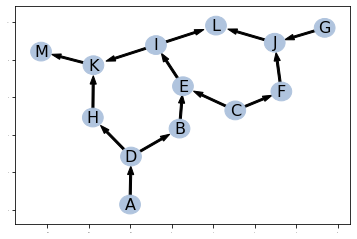

In [274]:
ptn = pattern()
ptn.add_edges([
    ('A', 'D'),
    ('D', 'B'),
    ('B', 'E'),
    ('C', 'E'),
    ('C', 'F'),
    ('D', 'H'),
    ('E', 'I'),
    ('F', 'J'),
    ('H', 'K'),
    ('I', 'K'),
    ('I', 'L'),
    ('J', 'L'),
    ('G', 'J'),
    ('K', 'M')
])
ptn.draw()

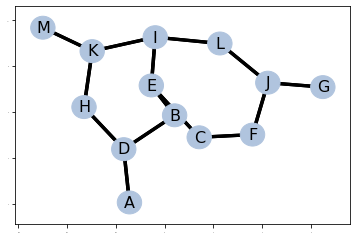

In [275]:
ptn = pattern()
ptn.add_links([
    ('A', 'D'),
    ('D', 'B'),
    ('B', 'E'),
    ('C', 'E'),
    ('C', 'F'),
    ('D', 'H'),
    ('E', 'I'),
    ('F', 'J'),
    ('H', 'K'),
    ('I', 'K'),
    ('I', 'L'),
    ('J', 'L'),
    ('G', 'J'),
    ('K', 'M')
])
ptn.draw()

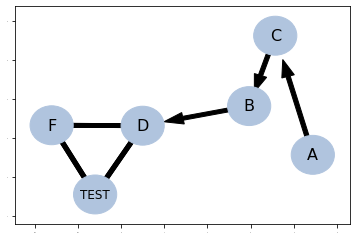

In [276]:
ptn = pattern()
ptn.add_edges([
    ('A', 'C'),
    ('C', 'B'),
    ('B', 'D'),
])
ptn.add_links([
    ('D', 'TEST'),
    ('D', 'F'),
    ('TEST', 'F'),
])
ptn.draw()

In [277]:
pos

{'A': array([-2.00774694,  0.26659645]),
 'M': array([-6.29973272,  8.42769388]),
 'F': array([5.28869548, 6.30082386]),
 'E': array([0.54443721, 6.58074632]),
 'H': array([-3.80148305,  4.90954588]),
 'I': array([-0.75749148,  8.77704169]),
 'D': array([-1.96099263,  2.82784348]),
 'C': array([3.0662033 , 5.28958469]),
 'B': array([0.37797456, 4.31934677]),
 'G': array([7.37738887, 9.69550624]),
 'K': array([-3.77390147,  7.7015522 ]),
 'L': array([2.1374041 , 9.81496078]),
 'J': array([4.96888993, 8.90195286])}

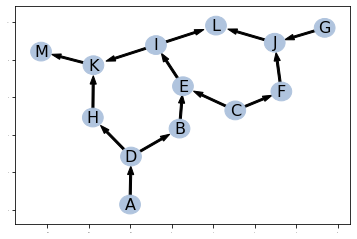

In [237]:
ptn.draw_graph_by_pos(pos)

##### 시발

In [280]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform

def gaussian_kernel(data:pd.DataFrame, X:set, sigma:float = None, unit_variance:bool = False) -> np.array:
    X = data.loc[:, list(X)].to_numpy()#.transpose()
    if not unit_variance:
        X = X/X.std(axis=0)

    # from https://stats.stackexchange.com/questions/15798/how-to-calculate-a-gaussian-kernel-effectively-in-numpy
    dist = squareform(pdist(X, 'euclidean'))
    if not sigma : 
      n = len(dist)
      sigma = np.median(dist[np.triu_indices(n, k = 1)])
    K = np.exp(-dist**2/ (2*sigma**2))
    return K

def centralized_gaussian_kernel(data:pd.DataFrame, X:set, sigma:float = None, unit_variance:bool = False) -> np.array:
    K = gaussian_kernel(data, X, sigma, unit_variance)
    n = len(K)
    H = np.identity(n) - np.ones((n, n))/n
    return np.matmul(np.matmul(H, K), H)

def kcit(data:pd.DataFrame, X:set, Y:set, Z:set = None, regulation:float = 1e-3, alpha:float = 0.05, beta:float = 1, unit_variance:bool = False, **test_kwarg) -> bool:
    # hyper parameter setting
    hyper_parameter = dict()

    if len(data) < 200: hyper_parameter['width'] = 0.8
    elif len(data) > 1200: hyper_parameter['width'] = 0.3
    else: hyper_parameter['width'] = 0.5 

    for kw, value in test_kwarg.items():
        hyper_parameter[kw] = value

    n = len(data)
    # Independence Test
    if Z is None:
        Kx = centralized_gaussian_kernel(data, X, unit_variance)
        Ky = centralized_gaussian_kernel(data, Y, unit_variance)

        T = np.matmul(Kx, Ky).trace() / n
        E_T = Kx.trace() * Ky.trace() / (n**2)
        V_T = 2 * np.matmul(Kx, Kx).trace() * np.matmul(Ky, Ky).trace() / (n**4)

        k = E_T**2 / V_T
        theta = V_T/E_T 
    
    else:
        # X = [X, Z]
        X = X|Z

        # Kx, Ky, Kz <- centralized kernel matrix of X, Y, Z with hyper_parameter['width']
        Kx = centralized_gaussian_kernel(data, X, hyper_parameter['width'])
        Ky = centralized_gaussian_kernel(data, Y, hyper_parameter['width'])
        Kz = centralized_gaussian_kernel(data, Z, hyper_parameter['width'])
        
        Rz = regulation * np.linalg.inv(Kz + regulation * np.identity(n))
        Kxz = np.matmul(np.matmul(Rz, Kx), Rz)
        Kyz = np.matmul(np.matmul(Rz, Ky), Rz)

        Lxz, Vx = np.linalg.eig(Kxz)
        Lyz, Vy = np.linalg.eig(Kyz)

        # soring eigenvalues and corresponding eigenvectors
        idx = Lxz.argsort()
        Lxz, Vx = Lxz[idx], np.real(Vx[:, idx])
        idx = Lyz.argsort()
        Lyz, Vy = Lyz[idx], np.real(Vy[:, idx])

        # diag(Vx(Vy.T))
        W = np.zeros(n)
        for t in range(n):
            W[t] = np.inner(Vx[t], Vy[t])

        # W = W(W.T)
        W = np.asmatrix(W)
        W = np.matmul(W, W.transpose())

        T = np.matmul(Kxz, Kyz).trace().item()/n
        E_T = W.trace().item()/n
        V_T = 2 * np.matmul(W, W).trace().item()/(n**2)
    
        k = E_T**2 / V_T
        theta = 1/np.log10(E_T/V_T) 
        # theta = V_T/E_T * np.sqrt(n)

    cri = stats.gamma(a = k, scale = theta).ppf(1 - alpha)
    
    return T < cri

In [315]:
class cpc:
    def __init__(self):
        self.ptn = pattern()
    
    def identify(self, data:pd.DataFrame = None, test:str = None, ind:dict = None, vertex = None, **test_kwarg) -> pattern: 
        # self.test = self.get_test(test)

        # STEP 0 ~ 1 : Find skeleton
        if ind is not None:
            self.identify_skeleton_by_ind(ind, vertex)
        else:
            self.identify_skeleton_from_full_link_graph(data, test_kwarg = test_kwarg)


        # # STEP 2 : Find v-structure and unfaithful triple
        self.identify_v_structure_with_adjacency_faithfulness()

        # STEP 3~5 : use Meek's rules
        cnt = True
        while cnt:
          cnt2 = self.identify_meeks_rule_2_in_cpc()
          # STEP 3 is not related with orient faithfulness assumption.
          # Because it uses only the definition of DAG
          cnt3 = self.identify_meeks_rule_3() 
          cnt4 = self.identify_meeks_rule_4_in_cpc()

          cnt = cnt2 or cnt3 or cnt4 # Check there are vertexs which could be changed

        return self.ptn
    
    def draw(self):
        self.ptn.draw()
        pos = self.ptn.pos
        for triple in self.unfaithful_triple:
            x, z, y = triple
            
            delta = pos[x] - pos[y]
            l = np.linalg.norm(delta) * 30 / 100
            unit = delta/np.linalg.norm(delta)

            cent = (pos[x] + pos[y]) / 2
            cent = 3 * pos[z]/4 + cent/4
            x, y = cent - unit * l / 2
            dx, dy = unit * l
            plt.arrow(x, y, dx, dy, width = 0.05, color = 'gray', linestyle = '-.')
    
    def draw_by_pos(self, pos):
        self.ptn.draw_by_pos(pos)
        for triple in self.unfaithful_triple:
            x, z, y = triple
            
            delta = pos[x] - pos[y]
            l = np.linalg.norm(delta) * 30 / 100
            unit = delta/np.linalg.norm(delta)

            cent = (pos[x] + pos[y]) / 2
            cent = 3 * pos[z]/4 + cent/4
            x, y = cent - unit * l / 2
            dx, dy = unit * l
            plt.arrow(x, y, dx, dy, width = 0.05, color = 'gray', linestyle = '-.')

        
cpc.identify_skeleton_from_full_link_graph = identify_skeleton_from_full_link_graph
cpc.identify_v_structure_with_adjacency_faithfulness = identify_v_structure_with_adjacency_faithfulness
cpc.identify_meeks_rule_2_in_cpc = identify_meeks_rule_2_in_cpc
cpc.identify_meeks_rule_3 = identify_meeks_rule_3
cpc.identify_meeks_rule_4_in_cpc = identify_meeks_rule_4_in_cpc
cpc.identify_skeleton_by_ind = identify_skeleton_by_ind

#### Test 1

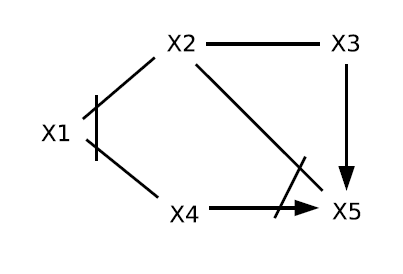

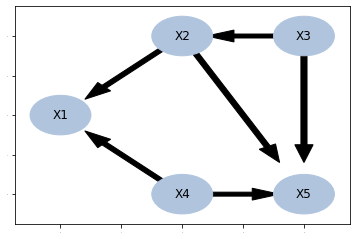

In [317]:
ptn = pattern()
ptn.add_edges([
    ('X2', 'X1'),
    ('X4', 'X1'),
    ('X4', 'X5'),
    ('X2', 'X5'),
    ('X4', 'X5'),
    ('X3', 'X2'),
    ('X3', 'X5')
])
pos = {
    'X1' : np.array([0, 2]),
    'X2' : np.array([2, 4]),
    'X4' : np.array([2, 0]),
    'X3' : np.array([4, 4]),
    'X5' : np.array([4, 0])
}
ptn.draw_by_pos(pos)

In [318]:
ds = ptn.get_all_d_separation()

In [322]:
ds['X2']['X4'].add(tuple(['X1']))
ds['X2']['X4'].add(tuple(['X5']))
ds

defaultdict(<function __main__.pattern.__init__.<locals>.<lambda>()>,
            {'X2': defaultdict(set,
                         {'X4': {(), ('X1',), ('X3',), ('X5',)},
                          'X1': set(),
                          'X3': set(),
                          'X5': set()}),
             'X4': defaultdict(set,
                         {'X2': {(), ('X1',), ('X3',), ('X5',)},
                          'X3': {(), ('X2',), ('X2', 'X1')},
                          'X5': set()}),
             'X1': defaultdict(set,
                         {'X3': {('X2',), ('X2', 'X4')},
                          'X5': {('X2', 'X4')},
                          'X4': set()}),
             'X3': defaultdict(set,
                         {'X1': {('X2',), ('X2', 'X4')},
                          'X4': {(), ('X2',), ('X2', 'X1')},
                          'X5': set()}),
             'X5': defaultdict(set, {'X1': {('X2', 'X4')}})})

In [323]:
cpc_algorithm = cpc()
cpc_algorithm.identify(ind = ds, vertex = ptn.vertex)

In [324]:
cpc_algorithm.unfaithful_triple

{('X2', 'X1', 'X4'),
 ('X2', 'X5', 'X4'),
 ('X4', 'X1', 'X2'),
 ('X4', 'X5', 'X2')}

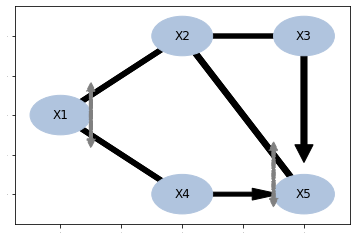

In [325]:
cpc_algorithm.draw_by_pos(pos)

In [ ]:
import numpy as np
import scipy.stats as stats
import pandas as pd
from collections import defaultdict
from itertools import combinations, chain

data = pd.DataFrame()
error = stats.norm()

data['A'] = stats.norm(loc = 3).rvs(size = 1000)
data['B'] = stats.norm(loc = 3).rvs(size = 1000)
data['D'] = stats.norm(loc = 3).rvs(size = 1000)

data['C'] = 3 * data['A'] * data['B'] * data['D'] + error.rvs(size = 1000)
data.shape

(1000, 4)

In [ ]:
pc_algorithm = pc()
pc_algorithm.identify(data, {})

In [ ]:
# bsc.test = kcit

In [ ]:
# bsc.identify_skeleton_from_empty_graph(data, {})

In [ ]:
p_ind = pc_algorithm.p_independence_set
print('AB', p_ind['A']['B'])
print('AC', p_ind['A']['C'])
print('AD', p_ind['A']['D'])
print('BC', p_ind['B']['C'])
print('BD', p_ind['B']['D'])
print('CD', p_ind['C']['D'])

AB {('D',), ()}
AC set()
AD {(), ('B',)}
BC set()
BD {(), ('A',)}
CD set()


In [ ]:
pc_algorithm.ptn.draw()

D -> C {}
B -> C {}
A -> C {}


#### Test 2

In [ ]:
ptn = pattern()
ptn.add_edges([
    ('B', 'A'),
    ('C', 'A'),
    ('B', 'D'),
    ('C', 'D'),
    ('D', 'E')
])
ds = ptn.get_all_d_separation()

In [ ]:
bsc = basic()
bsc.identify(ind = ds, vertex = ptn.vertex)
bsc.ptn.draw()

C -> A {}
C -> D {}
B -> A {}
B -> D {}
D -> E {}


In [ ]:
ptn = pattern()

In [ ]:
ptn.add_edges([
    ('A', 'D'),
    ('D', 'B'),
    ('B', 'E'),
    ('C', 'E'),
    ('C', 'F'),
    ('D', 'H'),
    ('E', 'I'),
    ('F', 'J'),
    ('H', 'K'),
    ('I', 'K'),
    ('I', 'L'),
    ('J', 'L'),
    ('G', 'J'),
    ('K', 'M')
])

In [ ]:
ptn.draw()

C -> E {}
C -> F {}
B -> E {}
K -> M {}
F -> J {}
J -> L {}
D -> B {}
D -> H {}
A -> D {}
G -> J {}
E -> I {}
H -> K {}
I -> K {}
I -> L {}


In [ ]:
ptn.get_descendant('A')

{'B', 'D', 'E', 'H', 'I', 'K', 'L', 'M'}

In [ ]:
ptn.get_ancestor('D')

{'A'}

In [ ]:
ptn.get_path('A', 'G')

[]

In [ ]:
ptn.get_path('A', 'M')

[['A', 'D', 'B', 'E', 'I', 'K', 'M'], ['A', 'D', 'H', 'K', 'M']]

In [ ]:
ptn.get_path('A', 'G', directed = False)

[['A', 'D', 'B', 'E', 'I', 'L', 'J', 'G'],
 ['A', 'D', 'B', 'E', 'C', 'F', 'J', 'G'],
 ['A', 'D', 'B', 'E', 'C', 'F', 'J', 'G'],
 ['A', 'D', 'H', 'K', 'I', 'L', 'J', 'G'],
 ['A', 'D', 'H', 'K', 'I', 'E', 'C', 'F', 'J', 'G'],
 ['A', 'D', 'H', 'K', 'I', 'E', 'C', 'F', 'J', 'G'],
 ['A', 'D', 'B', 'E', 'I', 'L', 'J', 'G'],
 ['A', 'D', 'B', 'E', 'C', 'F', 'J', 'G'],
 ['A', 'D', 'B', 'E', 'C', 'F', 'J', 'G'],
 ['A', 'D', 'H', 'K', 'I', 'L', 'J', 'G'],
 ['A', 'D', 'H', 'K', 'I', 'E', 'C', 'F', 'J', 'G'],
 ['A', 'D', 'H', 'K', 'I', 'E', 'C', 'F', 'J', 'G']]

In [ ]:
ptn.get_d_separation({'M'}, {'E', 'I'})

{'G'}

In [ ]:
ptn.d_separated({'M'}, {'J'}, {'E', 'I'})

False